# Transfer Learning in Computer Vision

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-11-25 18:23:57--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.49, 52.85.79.72, 52.85.79.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  44.5MB/s    in 1.0s    

2021-11-25 18:23:58 (44.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


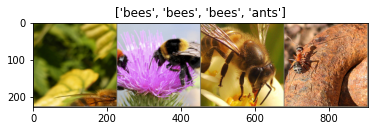

In [5]:
# Visualize a few images

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean 
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs -1))
    print("-" * 10)

    # Train and val
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero parameter gradients
        optimizer.zero_grad()

        # Forward
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize ony if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects +=torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() /dataset_sizes[phase]

      print("{} Loss: {:.4f} Acc: {:.4f}".format(
          phase, epoch_loss, epoch_acc
      ))

      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
    print()
  
  time_elapsed = time.time() - since
  print("Training comple in {:.0f}m {:.0f}s".format(
      time_elapsed // 60, time_elapsed % 60
  ))

  print("Best val Acc: {:4f}".format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model

## Fine Tuning

In [7]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5191 Acc: 0.7049
val Loss: 0.2118 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.3757 Acc: 0.8443
val Loss: 0.4006 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4484 Acc: 0.8115
val Loss: 0.2722 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5982 Acc: 0.7787
val Loss: 0.4293 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5788 Acc: 0.7623
val Loss: 0.1663 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4681 Acc: 0.8156
val Loss: 0.4798 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5425 Acc: 0.8156
val Loss: 0.4297 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.5044 Acc: 0.8402
val Loss: 0.2410 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2801 Acc: 0.8852
val Loss: 0.2044 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2923 Acc: 0.8811
val Loss: 0.2417 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2294 Acc: 0.9016
val Loss: 0.2094 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3414 Acc: 0.8525
val Loss: 0.2498 Acc: 0.9085

Epoch 12/24
----------
t

In [11]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()

  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title("Predicted: {}".format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    
    model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


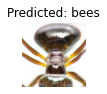

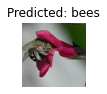

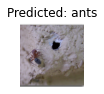

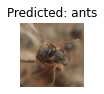

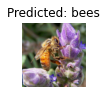

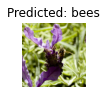

In [12]:
visualize_model(model_ft)

## ConvNet as Fixed Feature Extractor

In [16]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8138 Acc: 0.5861


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.4322 Acc: 0.7712

Epoch 1/24
----------
train Loss: 0.5713 Acc: 0.7541
val Loss: 0.1765 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4393 Acc: 0.8197
val Loss: 0.1726 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3700 Acc: 0.8238
val Loss: 0.1490 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3951 Acc: 0.8279
val Loss: 0.1415 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4204 Acc: 0.8074
val Loss: 0.1557 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3120 Acc: 0.8689
val Loss: 0.2122 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3981 Acc: 0.8115
val Loss: 0.2339 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3612 Acc: 0.8566
val Loss: 0.3696 Acc: 0.8562

Epoch 9/24
----------
train Loss: 0.3854 Acc: 0.8279
val Loss: 0.3319 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3643 Acc: 0.8484
val Loss: 0.1473 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3931 Acc: 0.8320
val Loss: 0.1710 Acc: 0.9281

Epoch 12/24
----------
train Loss: 0.3090 Acc: 0.8607
v

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


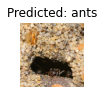

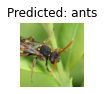

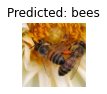

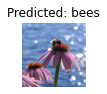

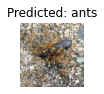

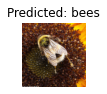

In [18]:
visualize_model(model_conv)
plt.ioff()
plt.show()